In [1]:
#The following notebook is an example of the simulations that I performed for my graduate school reasearch.
#At its core, it is a quantum mechanical simulation that is described and manipulated used matrices and linear algebra.
#
#
#The simulation generates a final NMR spectrum of three peaks.  
#Here, I use this code to determine the level of signal distortion expected after a "quadrupolar echo" NMR experiment, diagrammed below:
#
#     0  1             2  3            4
#      __               __             . 
#     |  |             |  |            .
#     |P1|     tau1    |P2|     tau2   .    ACQ
#_____|  |_____________|  |__________________________
#
#The x-axis is time, and the system is explicitly calculated at 5 points (labeled 0-4).
#The system is manipulated through pulses of energy (P1 and P2), or by simply waiting time (tau1 and tau2).
#The simulated signal can then be generated at time point 4 (labeled "ACQ" for "acquisition" of signal.)
#
#There are a few suggested variables that can played with to see how the distortion changes:
#    T, tipangle1, tipangle2, tau1


In [2]:
#INITIAL IMPORTS AND DEFINITIONS

import numpy as np
from numpy.linalg import *
import scipy as sp
import scipy.linalg
import cmath
from math import *
import matplotlib.pyplot as plt

def trace(n): return np.trace(n)      #Shorthand to take the trace of a matrix.
def exp(n): return cmath.exp(n)       #Shorthand to take the exponent of a value.
def expm(n): return sp.linalg.expm(n) #Shorthand to take the exponent of a matrix.
def sqrt(n): return n**(1/2)          #Shorthand to take the square root of a value.
def fact(n):                          #Shorthand for factorial.  (Surprisingly not initially a well-defined function!)
    if n == 0:
        return 1
    else:
        return n * fact(n-1)

def LVN(R,M): 
    '''
    Implement the solution for the von Neumann equation for NMR density matrices.
    
    Parameters:
        R: The rotation operator (in matrix form) being implemented
        M: The  density matrix to be transformed.
    
    Returns:
        The transformed density matrix
    '''
    
    return np.matmul(np.matmul(R,M),np.linalg.inv(R))
def PauliMatrices(I):
    '''
    Generates the spin operators for any-sized spin quantum number in array form.
    
    Implementation of an established and common derivation in the literature.  https://www.easyspin.org/documentation/spinoperators.html
    
    Parameters:
        I: Spin quantum number of the nucleus/spin (integer or half-integer only)
    
    Returns:
        Sx: Spin operator that corresponds to the projection along the x-axis.
        Sy: Spin operator that corresponds to the projection along the y-axis.
        Sy: Spin operator that corresponds to the projection along the y-axis.
        Splus: Spin operator that corresponds to the raising of magnetic quantum number.
        Sminus: Spin operator that corresponds to the lowering of magnetic quantum number.
    '''
    
    j_a = np.linspace(-I,I-1,int(2*I))
    k_a = np.linspace(-I,I,int(2*I+1))
    N = int(2*I+1)
    Splus  = np.zeros((N,N))
    Sminus = np.zeros((N,N))
    Sz = np.zeros((N,N))
    for j in j_a:
        m_s = j
        Splus[int(j+I),int(j+I+1)] = (I*(I+1)-m_s*(m_s+1))**(1/2)
        Sminus[int(j+I+1),int(j+I)] = (I*(I+1)-(m_s+1)*m_s)**(1/2)

    Sx = (Splus+Sminus)/2
    Sy = -1j*((Splus-Sminus))/2

    for k in k_a:
        Sz[(int(-k+I),int(-k+I))] = k
    return [Sx,Sy,Sz,Splus,Sminus]


def Wig(I,theta):
    '''
    Generates the Wigner rotation operators for Hermitian square matrices that apply to a particle with spin I.
    
    Wigner matrices are high-level operators that are useful tools for mathematically manipulating an angular momentum quantum mechanical system (spin!) while using the language of rotations.
    This operator is currently written as a rotation about the y-axis
    Implementation of an established and common derivation in the literature.  
    Wigner, Eugene. Group theory: and its application to the quantum mechanics of atomic spectra. Vol. 5. Elsevier, 2012.
    
    Parameters:
        I: Spin quantum number of the nucleus/spin (integer or half-integer only)
        theta: the rotation angle of the rotation being applied
    
    Returns:
        The Wigner rotation matrix in the y-direction
    '''
    mp_a = np.linspace(-I,I,int(2*I+1))
    m_a  = np.linspace(-I,I,int(2*I+1))
    s_a = np.linspace(0,2*I,int(2*I+1))
    d = np.zeros((int(2*I+1),int(2*I+1)))+1j*np.zeros((int(2*I+1),int(2*I+1)))
    for mp in mp_a:
        for m in m_a:
            sum = 0
            for s in s_a:
                if I+m-s >=0 and s >=0 and mp-m+s >=0 and I-mp-s >=0:
                    B = ((-1)**(s)*sqrt(fact(I+mp)*fact(I-mp)*fact(I+m)*fact(I-m)))/(fact(I+m-s)*fact(s)*fact(mp-m+s)*fact(I-mp-s))
                    C = (cos(theta/2))**(2*I+m-mp-(2*s))
                    D = (sin(theta/2))**(mp-m+(2*s))
                    sum = sum+B*exp(-1*1j*np.pi/2*mp)*C*D*exp(1j*np.pi/2*mp)
            d[int(mp+I),int(m+I)] = sum
    return d

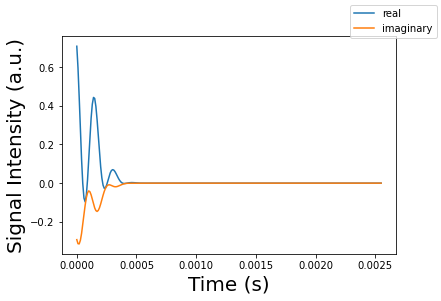

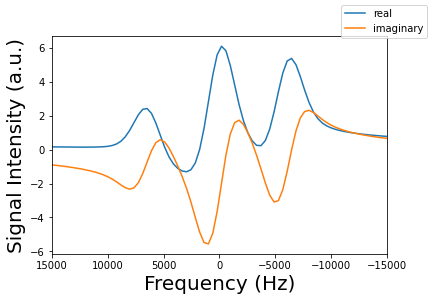

In [3]:
#THE CODE

#Suggested 'manipulatable' variables:
T  = -0.0015                #Experimental temperature, Kelvin
tipangle1 = -55             #Tip angle of pulse 1, degrees
tipangle2 = -55             #Tip angle of pulse 2, degrees
tau1 = 25*10**-6             #time tau1, seconds
tau2 = tau1                  #time tau2, seconds  (almost always the same as tau1)


#Constants and variables:
kB = 2.0836612*10**10       #Boltzmann Constant, Hz/Kelvin
B0 = 7                      #Magnetic field strength, Tesla
I = 3/2                     #Spin quantum number of 75As
gamma_75As =7.2919*10**6    #gyromagnetic ratio of 75As nuclei, Hz/Tesla
T2 = 0.0002                 #Line broadening time constant, seconds
nuQ = 6000                  #Quadrupolar splitting, Hz
nuOffset = 0                #Carrier frequency offset, Hz
dwell = 10*10**-6           #dwell time of signal acquisition, s
numpoint = 2**8             #number of data points acquired
         

#Define Spin Matrices 
[Ix,Iy,Iz,Iplus,Iminus] = PauliMatrices(I) #These matrices are the 'building blocks' of this type of quantum mechanical simulations.  They'll show up in every line in some form.


#Hamiltonians (the quantum mechanical descriptions of energy couplings, and such)
H_Z = -gamma_75As*Iz*2*np.pi                                    #Zeeman Interaction
H_1Q = nuQ/6*(3*Iz**2-I*(I+1)*np.identity(int(2*I+1)))*2*np.pi  #First-order Quadrupolar
H_Offset = nuOffset*Iz*2*np.pi                                  #Offset freqency (for data simulation)
H_FID = H_1Q+H_Offset                                           #The Hamiltonian active during signal acquisition

#Derive initial density matrix. The "density matrix" is the matrix that describes the entire system at a given time.  In this case, at time = 0 (see diagram), the initial density matrix.'''

rho0 = expm(-H_Z/kB/T)/trace(expm(-H_Z/kB/T))  


#Define radio-frequency (RF) energy pulses, represented in matrix form.  These are highly common in NMR to manipulate density matrices in order to do cool physics.  
#They're often described with the language of rotations, hence the "tip angles."
P1 = expm(-1j*tipangle1/180*np.pi*Iy)      #RF pulse along the +y direction
P1 = expm(-1j*tipangle1/180*np.pi*Iy)      #There is a known sp.linalg.expm bug when handling sparse matrices.  Duplicating this line fixes it!
P2_pt1 = expm(-1j*tipangle2/180*np.pi*Ix)  #RF pulse along the +x direction, 
P2_pt1 = expm(-1j*tipangle2/180*np.pi*Ix)  #There is a known sp.linalg.expm bug when handling sparse matrices.  Duplicating this line fixes it!
P2_pt2 = expm(+1j*tipangle2/180*np.pi*Ix)  #RF pulse along the -x direction
P2_pt2 = expm(+1j*tipangle2/180*np.pi*Ix)  #There is a known sp.linalg.expm bug when handling sparse matrices.  Duplicating this line fixes it!

#Define the "wait times" between pulses, represented in matrix form.  Although there are no pulses during this time, the system will still evolve, influenced by certain Hamiltonians
#(specifically, the H_1Q Hamiltonian).
U1 = expm(-1j*H_1Q*tau1)
U2 = expm(-1j*H_1Q*tau2)

#Derive the density matrices at times 1-4 (see diagram).  This heavily relies on the background "Liouville-von Neumann" equation, which here, is a custom-defined function.
#rho0: The initial density matrix
#rho1: The density matrix immediately after the first RF pulse
#rho2: The density matrix immediately before the second RF pulse
#rho3: The density matrix immediately after the second RF pulse
#rho4: The density matrix used to generate signal

rho1 = LVN(P1,rho0)          #Calculate rho1 by inputting P1 and rho0
rho2 = LVN(U1,rho1)          #Calculate rho2 by inputting U1 and rho1
rho3_pt1 = LVN(P2_pt1,rho2)  #Calculate rho3 by inputting P2 and rho2
rho3_pt2 = LVN(P2_pt2,rho2)  
rho4_pt1 = LVN(U2,rho3_pt1)  #Calculate rho4 by inputting U2 and rho3
rho4_pt2 = LVN(U2,rho3_pt2)

rho3 = rho3_pt1/2+rho3_pt2/2     #The second pulse is done in two parts (hard to explain without a ton of theory), so the two parts of the density matrices are averaged.
rho4 = rho4_pt1/2+rho4_pt2/2     #The second pulse is done in two parts (hard to explain without a ton of theory), so the two parts of the density matrices are averaged.

#initialize the dimensions of the NMR spectra based on experimentally-controlled varaibles "dwell" and "numpoint."
time = np.linspace(0,(numpoint-1)*dwell,numpoint)
nu = np.linspace(-0.5*(1/dwell),0.5*(1/dwell),numpoint)

#Simulate the NMR signal
#Signal is detected in real-time as the density matrix evolves in real-time, under influence of the H_FID Hamiltonian.
rhostep = np.empty((numpoint,int(len(rho1)),int(len(rho1))),dtype=complex)  #initialize
signal = np.empty((numpoint),dtype=complex)                                 #initialize

for n in range(numpoint):
    rhostep[n,:,:] = LVN(expm(-1j*H_FID*time[n]),rho4)  #Evolution of the density matrix rho4 in real-time
    signal[n] = np.trace(np.matmul(rhostep[n,:,:],Iplus))*exp(-(n*dwell)**2/T2**2) #"Measurement" of signal, stored in the array "signal"

    
#Plot the time-domain signal 
plt.plot(time,signal.real)
plt.plot(time,signal.imag)
plt.xlabel('Time (s)',fontsize = 20)
plt.ylabel('Signal Intensity (a.u.)',fontsize = 20)
plt.figlegend(('real','imaginary'),loc='upper right')
plt.show()

#Plot the frequency-domain signal
fftsignal=np.fft.fftshift(np.fft.fft(signal))  #The signal can be fourier transformed into frequency domain, something arguably more useful to an NMR spectroscopist.
plt.plot(nu,fftsignal.real)
plt.plot(nu,fftsignal.imag)
plt.xlim(15000,-15000)
plt.xlabel('Frequency (Hz)',fontsize = 20)
plt.ylabel('Signal Intensity (a.u.)',fontsize = 20)
plt.figlegend(('real','imaginary'),loc='upper right')
plt.show()